In [2]:
from pandas import read_csv
from datetime import datetime
# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution2.csv')


                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43800 entries, 2010-01-02 00:00:00 to 2014-12-31 23:00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pollution  43800 non-null  float64
 1   dew        43800 non-null  int64  
 2   temp       43800 non-null  float64
 3   press      43800 non-null  float64
 4   wnd_dir    43800 non-null  object 
 5   wnd_spd    43800 non-null  float64
 6   snow       43800 non-null  int64  
 7   rain       43800 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 3.0+ MB


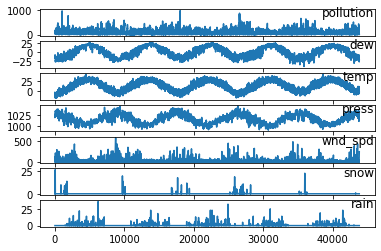

In [4]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

### Multivariate LSTM Forecast Model

In [7]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values

# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')

# normalize input features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

#frame as supervised learning
n_hours = 3 
n_features = 8 
reframed = series_to_supervised(scaled, n_hours, 1)
values = reframed.values
n_train_hours = 365*24 # This is the same as one year (24hrs by 365 days)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
 
#CHANGES HERE
#split into input and outputs
n_obs = n_hours * n_features
train_X = train[:, :n_obs]
train_y = train[:, -n_features:(-n_features+2)] #+2 because of indexing madness.
test_X = test[:, :n_obs]
test_y = test[:, -n_features:(-n_features+2)]
 
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
 
#CHANGES HERE
#Need to output two values, not one.
#design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(2)) #changed from 1 to 2.
model.compile(loss='mae', optimizer='adam')
 
#fit network
history = model.fit(train_X, train_y, epochs=40, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
 
#make a prediction
y_hat = model.predict(test_X)
 
#CHANGES HERE
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
inv_yhat = concatenate((y_hat, test_X[:,-6:]), axis=1) #changed 7 to 6
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0:2] #changed from 0 to 0:2. Should be first 2 columns that contain the predictions
 
#CHANGES HERE
#invert scaling for actual
test_y = test_y.reshape((len(test_y),2)) #changed 1 to 2
inv_y = concatenate((test_y, test_X[:,-6:]), axis=1) #changed 7 to 6
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0:2] #changed from 0 to 0:2. Should be first 2 columns that contain the predictions.
 
#CHANGES HERE
#calculate RMSE - CHANGED to output RMSE for each variable.
rmse_1 = sqrt(mean_squared_error(inv_y[:,0], inv_yhat[:,0])) #RMSE for the first variable (pollution)
rmse_2 = sqrt(mean_squared_error(inv_y[:,1], inv_yhat[:,0])) #RMSE for the second variable (dew)
print('Test RMSE: ', rmse_1, rmse_2)

Epoch 1/40
122/122 - 4s - loss: 0.0691 - val_loss: 0.1542 - 4s/epoch - 33ms/step
Epoch 2/40
122/122 - 1s - loss: 0.0396 - val_loss: 0.1403 - 1s/epoch - 11ms/step
Epoch 3/40
122/122 - 1s - loss: 0.0317 - val_loss: 0.1256 - 1s/epoch - 11ms/step
Epoch 4/40
122/122 - 1s - loss: 0.0287 - val_loss: 0.1168 - 1s/epoch - 11ms/step
Epoch 5/40
122/122 - 1s - loss: 0.0267 - val_loss: 0.1099 - 1s/epoch - 11ms/step
Epoch 6/40
122/122 - 1s - loss: 0.0248 - val_loss: 0.1019 - 1s/epoch - 11ms/step
Epoch 7/40
122/122 - 1s - loss: 0.0232 - val_loss: 0.0913 - 1s/epoch - 11ms/step
Epoch 8/40
122/122 - 1s - loss: 0.0218 - val_loss: 0.0826 - 1s/epoch - 11ms/step
Epoch 9/40
122/122 - 1s - loss: 0.0210 - val_loss: 0.0737 - 1s/epoch - 11ms/step
Epoch 10/40
122/122 - 1s - loss: 0.0205 - val_loss: 0.0676 - 1s/epoch - 11ms/step
Epoch 11/40
122/122 - 1s - loss: 0.0199 - val_loss: 0.0626 - 1s/epoch - 11ms/step
Epoch 12/40
122/122 - 1s - loss: 0.0194 - val_loss: 0.0576 - 1s/epoch - 11ms/step
Epoch 13/40
122/122 - 1s 

In [9]:
dt = read_csv("myTestData.csv")
dt

,date,temp,pressure,rain,humidity,pollution
0,01/01/2000,31,23,40,29,11
1,02/01/2000,39,40,5,41,23
2,03/01/2000,29,36,4,46,15
3,04/01/2000,5,37,37,1,27
4,05/01/2000,44,26,20,47,19
5,06/01/2000,0,47,12,44,16
6,07/01/2000,26,27,21,9,37
7,08/01/2000,47,1,38,25,27
8,09/01/2000,47,36,48,41,2
9,10/01/2000,12,31,32,36,47


In [13]:
series = series_to_supervised(dt,1,1)
series

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t)
1,01/01/2000,31.0,23.0,40.0,29.0,11.0,02/01/2000,39,40,5,41,23
2,02/01/2000,39.0,40.0,5.0,41.0,23.0,03/01/2000,29,36,4,46,15
3,03/01/2000,29.0,36.0,4.0,46.0,15.0,04/01/2000,5,37,37,1,27
4,04/01/2000,5.0,37.0,37.0,1.0,27.0,05/01/2000,44,26,20,47,19
5,05/01/2000,44.0,26.0,20.0,47.0,19.0,06/01/2000,0,47,12,44,16
6,06/01/2000,0.0,47.0,12.0,44.0,16.0,07/01/2000,26,27,21,9,37
7,07/01/2000,26.0,27.0,21.0,9.0,37.0,08/01/2000,47,1,38,25,27
8,08/01/2000,47.0,1.0,38.0,25.0,27.0,09/01/2000,47,36,48,41,2
9,09/01/2000,47.0,36.0,48.0,41.0,2.0,10/01/2000,12,31,32,36,47
